In [2]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set(style="darkgrid", palette="muted", font="serif")
plt.rcParams.update(plt.rcParamsDefault)

from abc import ABC, abstractmethod
import time
from typing import Callable, Tuple, List, Optional
import random
import itertools
from scipy.integrate import solve_ivp

from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *

plt.rcParams['xtick.labelsize'] = 14  # font size
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG

set_seed(42)

In [ ]:
# generate trajectories for the target system
dt = 0.1
num_points = 15
vdp_system = VanDerPol(mu=.3)
noise_level = 0.
time_span = torch.tensor([0.0, 5.0])
bounds = (-2.0, 2.0)  # Bounds for sampling
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    init_points_bounds=bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt, num_points=num_points,                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)

x = np.linspace(-2, 2, 15)
y = np.linspace(-2, 2, 15)
X, Y = np.meshgrid(x, y)
XY = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)

# Compute vector field
with torch.no_grad():
    dXY = vdp_system.forward(t=torch.tensor(0.0), x=XY).numpy()

U = dXY[:, 0].reshape(X.shape)
V = dXY[:, 1].reshape(Y.shape)

# Plotting
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.grid()
ax.quiver(X, Y, U, V, angles='xy')
plt.show()

limit_cycle_system = LimitCycle(dt=dt, time_span=time_span)
source_system_ra = RingAttractor(dt=dt, time_span=time_span)
A = torch.tensor([[-1.0, 0.0], [0.0, -1.0]], dtype=torch.float32)  #stable node
source_system_linear = LinearSystem(A, dt=dt, time_span=time_span)
motif_library = [limit_cycle_system, source_system_ra, source_system_linear]

limit_cycle_system = LearnableLimitCycle(dt=dt, time_span=time_span, speed_init=-1., lambda_init=-1.)
motif_library = [limit_cycle_system]

In [41]:
num_epochs = 100
layer_sizes=4*[64]
lr = 0.01
annealing_params = {'initial_std': .0, 'final_std': 0., 'dynamic': False}

homeo_lc = NODEHomeomorphism(dim=2, layer_sizes=layer_sizes)
#homeo_ra = NODEHomeomorphism(dim=2, layer_sizes=layer_sizes)
#homeo_net_linear = NODEHomeomorphism(dim=2, layer_sizes=layer_sizes)
homeo_networks = [homeo_lc] #, homeo_ra, homeo_net_linear]

homeo_ds_networks = train_all_motifs(motif_library, homeo_networks, trajectories_target, initial_conditions_target,
                                   lr=lr, num_epochs=num_epochs,
                                   annealing_params=annealing_params)

Training homeomorphism for motif: LearnableLimitCycle
Epoch 0, Loss: 0.2209
Speed:  -1.0100001  Lambda:  -0.892843
Epoch 10, Loss: 0.0336
Speed:  -0.99824256  Lambda:  -0.79645294
Epoch 20, Loss: 0.0220
Speed:  -0.9960274  Lambda:  -0.7041461
Epoch 30, Loss: 0.0132
Speed:  -0.9962176  Lambda:  -0.60477406
Epoch 40, Loss: 0.0071
Speed:  -0.9975809  Lambda:  -0.5048815
Epoch 50, Loss: 0.0033
Speed:  -0.9975414  Lambda:  -0.41536742
Epoch 60, Loss: 0.0017
Speed:  -0.9974037  Lambda:  -0.3517273
Epoch 70, Loss: 0.0009
Speed:  -0.9971301  Lambda:  -0.31827503
Epoch 80, Loss: 0.0005
Speed:  -0.9959865  Lambda:  -0.30224928
Epoch 90, Loss: 0.0004
Speed:  -0.9953901  Lambda:  -0.29286435
Total training time: 336.03 seconds, Avg time per epoch: 3.3603 sec


In [42]:
plot_first_n = 5
trajectories_target_array = np.array([traj.detach().numpy() for traj in trajectories_target])
trajectories_source_list, transformed_trajectories_list = test_homeo_networks(
    trajectories_target, motif_library, homeo_networks, generate_trajectories_scipy,
    time_span=np.array([0.0, 5.0]), plot_first_n=plot_first_n)

In [43]:
#find asymptotic behavior of target and source motifs
time_span = np.array([0.0, 100.0])

#test on unseen trajectories: generate new trajectories from the target system
t_values, asy_trajectory_target, asy_initial_condition_target = generate_trajectories(
    sampling_method='uniform', init_points_bounds=bounds, time_span=torch.tensor(time_span), 
    dt=.01, num_points=1, system=vdp_system)

trajectories_target_array = np.array([traj.detach().numpy() for traj in trajectories_target])
asy_trajectory_source_list, asy_transformed_trajectory_list = test_homeo_networks(
    trajectories_target, motif_library, homeo_networks, generate_trajectories_scipy, plot_first_n=1, time_span = time_span)


X = asy_trajectory_target[0,5000:,:].detach().numpy()
period_index = find_period_local_min(X) 
one_cycle = X[:int(period_index) + 1][::10,:]
uniform_points = resample_equal_arc_length(one_cycle, num_points=20)


In [44]:
# from_t = 200
# #asy_trajectory_target = 
# asy_trajectory_source_list = [asy_trajectory_source[0,from_t:,:] for asy_trajectory_source in asy_trajectory_source_list]
# asy_transformed_trajectory_list = [asy_transformed_trajectory[0,from_t:,:] for asy_transformed_trajectory in asy_transformed_trajectory_list]

thetas = np.linspace(0, 2*np.pi, 100)
xs = np.cos(thetas)
ys = np.sin(thetas)
ring = np.array([xs, ys]).T
ring_torch = torch.tensor(ring, dtype=torch.float32).to(device)
homeo_networks[0].eval()
asy_transformed_trajectory_list = [homeo_networks[0](ring_torch).detach().numpy()]
asymptotic_trajectories_list = [one_cycle] + asy_transformed_trajectory_list

In [45]:
from matplotlib.axes import Axes

def set_axis_ticks_with_zero(ax: Axes) -> None:
    xlims = ax.get_xlim()
    ticks = [xlims[0], 0, xlims[1]]
    
    formatter = plt.FuncFormatter(lambda x, _: f"{x:g}" if x in ticks else "")
    
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

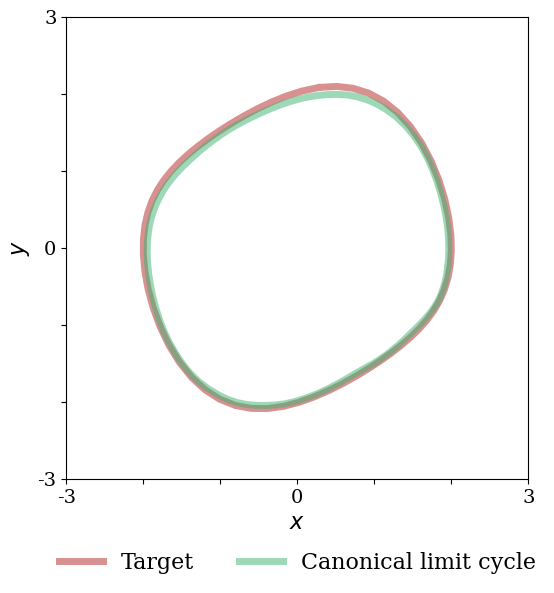

In [46]:
#plot asymptotic trajectories
color_dict = {
    'target': 'firebrick',
    'source_lc': 'mediumseagreen',
    'source_ra': '#00BFFF',
    'source_sn': '#8B008B',
    'asymptotic_target': '#d3869b',
    'asymptotic_0': 'seagreen',
    'asymptotic_1': 'navy',
    'asymptotic_2': 'purple',
}
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$y$', fontsize=16)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(asymptotic_trajectories_list[0][:, 0], asymptotic_trajectories_list[0][:, 1], '-', color=color_dict['target'], alpha=0.5, lw=5, label='Target')
ax.plot(asymptotic_trajectories_list[1][:, 0], asymptotic_trajectories_list[1][:, 1], '-', color=color_dict['source_lc'], alpha=0.5, lw=5, label='Canonical limit cycle')
ax.legend(loc='lower center',    bbox_to_anchor=(0.5, -0.25),ncol=3,fontsize=16,frameon=False)
set_axis_ticks_with_zero(ax)
plt.savefig('figures/vdp_node_tp_asy.pdf', dpi=300, bbox_inches='tight')

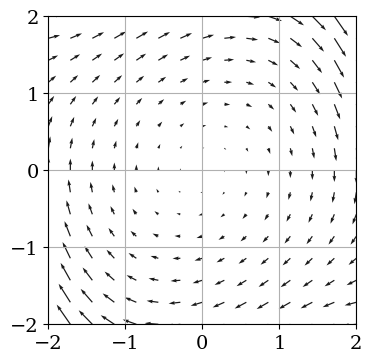

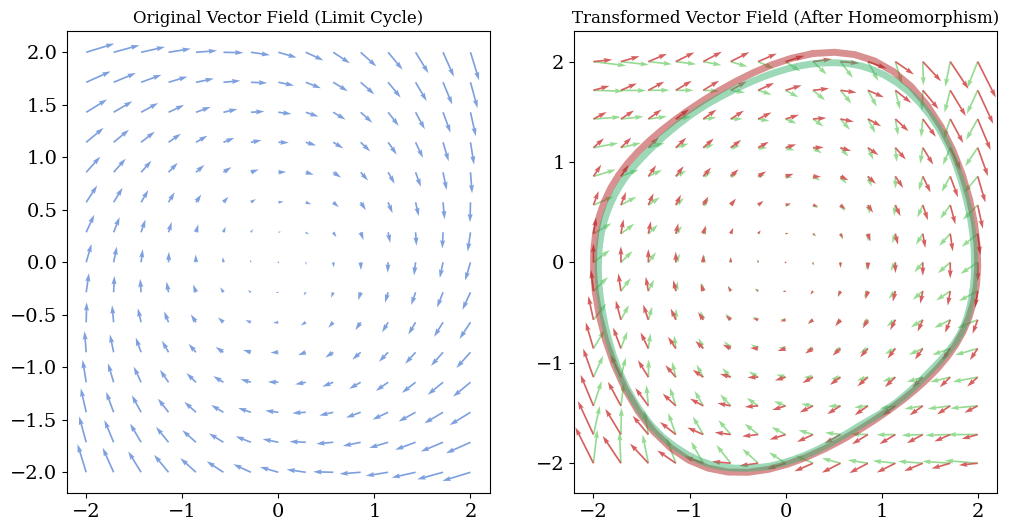

In [61]:
def plot_transformed_vector_field(homeo_ds_net, x_range=(-2, 2), y_range=(-2, 2), grid_size=15):
    """
    Plot the transformed vector field of a dynamical system using the learned homeomorphism.

    :param homeo_net: The learned homeomorphism network.
    :param dynamical_system: The dynamical system (e.g., LimitCycle).
    :param x_range: The range of x values for the grid.
    :param y_range: The range of y values for the grid.
    :param grid_size: The resolution of the grid.
    """
    dynamical_system = homeo_ds_net.dynamical_system
    homeo_net = homeo_ds_net.homeo_network
    # Create a meshgrid of points in phase space
    x_vals = np.linspace(x_range[0], x_range[1], grid_size)
    y_vals = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)

    # Convert grid points to torch tensor and move to device
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

    # Compute the vector field from the dynamical system at these points
    vector_field = dynamical_system.forward(None, grid_tensor)

    # Transform the vector field using the homeomorphism
    transformed_points = homeo_net.forward(grid_tensor)

    # Compute the transformed vector field
    transformed_vector_field = dynamical_system.forward(None, transformed_points)

    # Reshape to plot the vector field
    dx_dt = vector_field[:, 0].detach().cpu().numpy().reshape(X.shape)
    dy_dt = vector_field[:, 1].detach().cpu().numpy().reshape(Y.shape)
    
    dx_dt_transformed = transformed_vector_field[:, 0].detach().cpu().numpy().reshape(X.shape)
    dy_dt_transformed = transformed_vector_field[:, 1].detach().cpu().numpy().reshape(Y.shape)

    # Plot the original and transformed vector fields
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Original vector field
    ax[0].quiver(X, Y, dx_dt, dy_dt, color='b', alpha=0.7)
    ax[0].set_title("Original Vector Field (Limit Cycle)")

    # Transformed vector field
    ax[1].quiver(X, Y, dx_dt_transformed, dy_dt_transformed, color='g', alpha=0.7)
    ax[1].set_title("Transformed Vector Field (After Homeomorphism)")

    ax[1].quiver(X, Y, U, V, angles='xy', color='r')

    ax[1].plot(asymptotic_trajectories_list[0][:, 0], asymptotic_trajectories_list[0][:, 1], '-', color=color_dict['target'], alpha=0.5, lw=5, label='Target')
    ax[1].plot(asymptotic_trajectories_list[1][:, 0], asymptotic_trajectories_list[1][:, 1], '-', color=color_dict['source_lc'], alpha=0.5, lw=5, label='Canonical limit cycle')
    #plt.show()

# Assuming `homeo_lc` is your trained `NODEHomeomorphism` and `LimitCycle` is an instance of the dynamical system

plot_transformed_vector_field(homeo_ds_networks[0])



C:\Users\abel_\AppData\Local\Temp\ipykernel_24644\77045471.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_tensor = torch.tensor(grid_points, dtype=torch.float32)


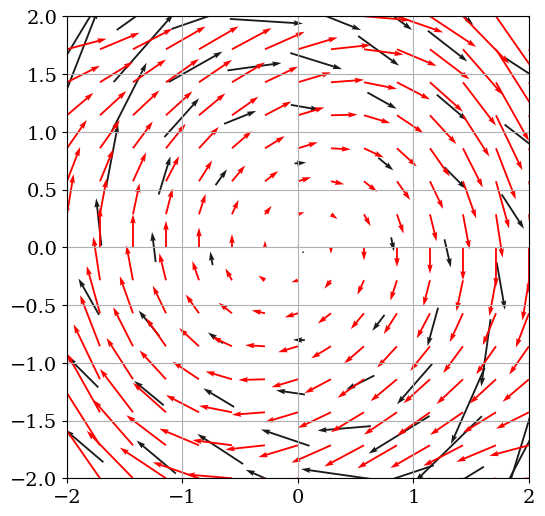

In [ ]:
# transformed_points, transformed_vector_field = transform_vector_field(homeo_ds_networks[0])
# plot_transformed_vector_field(transformed_points, transformed_vector_field)


['Target', 'Transformed Limit Cycle', 'Asymptotic Limit Cycle', 'Asymptotic target']


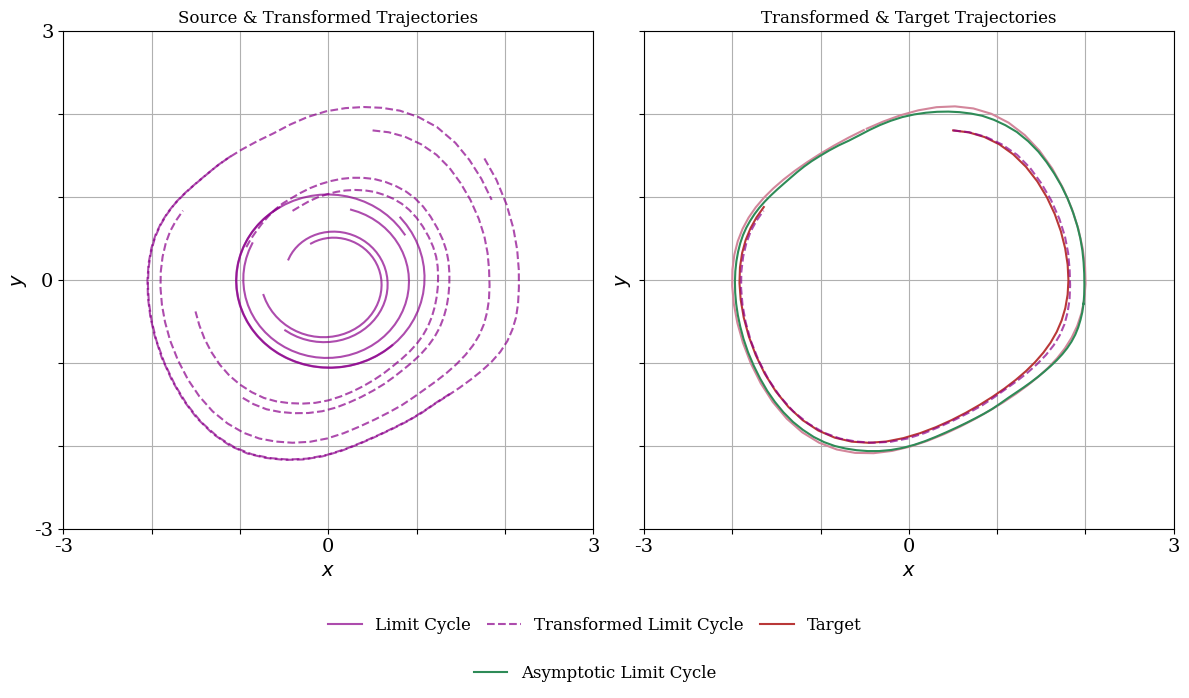

In [106]:
plot_first_n = 1
fig, axes = plot_trajectories_allmotifs(trajectories_source_list[:], transformed_trajectories_list[:], trajectories_target_array[:plot_first_n,:], bounds=(3.0, 3.0),
                            source_names=['Limit Cycle', 'Ring Attractor', 'Linear'],
                            asymptotic_trajectories_list=asymptotic_trajectories_list)
                            # save_name='figures/node_vdp_lc_speed_asym.pdf')

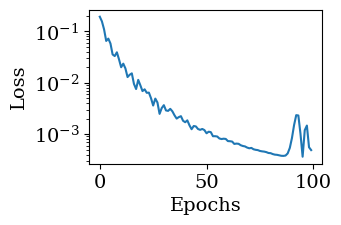

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(homeo_lc.losses)
ax.set_yscale('log')
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
plt.show()

# Normalizing flow

In [ ]:
num_epochs = 100
layer_sizes=4*[64]
homeo_lc = NormFlowDiffeomorphism(dim=2, layer_sizes=layer_sizes)
homeo_ra = NormFlowDiffeomorphism(dim=2, layer_sizes=layer_sizes)
homeo_net_linear = NormFlowDiffeomorphism(dim=2, layer_sizes=layer_sizes)
homeo_networks = [homeo_lc, homeo_ra, homeo_net_linear]
homeo_networks = train_all_motifs(motif_library, homeo_networks, trajectories_target, initial_conditions_target,
                                   lr=0.0001, num_epochs=num_epochs)

Training diffeomorphism for motif: LimitCycle
Epoch 0, Loss: 0.3087
Epoch 10, Loss: 0.2702
Epoch 20, Loss: 0.2223
Epoch 30, Loss: 0.1663
Epoch 40, Loss: 0.1031
Epoch 50, Loss: 0.0505
Epoch 60, Loss: 0.0416
Epoch 70, Loss: 0.0387
Epoch 80, Loss: 0.0364
Epoch 90, Loss: 0.0349
Total training time: 121.51 seconds, Avg time per epoch: 1.2151 sec
Training diffeomorphism for motif: RingAttractor
Epoch 0, Loss: 2.1926
Epoch 10, Loss: 2.1171
Epoch 20, Loss: 2.0379
Epoch 30, Loss: 1.9570
Epoch 40, Loss: 1.8790
Epoch 50, Loss: 1.8091
Epoch 60, Loss: 1.7494
Epoch 70, Loss: 1.6977
Epoch 80, Loss: 1.6512
Epoch 90, Loss: 1.6106
Total training time: 117.16 seconds, Avg time per epoch: 1.1716 sec
Training diffeomorphism for motif: LinearSystem
Epoch 0, Loss: 1.5209
Epoch 10, Loss: 1.5166
Epoch 20, Loss: 1.5161
Epoch 30, Loss: 1.5162
Epoch 40, Loss: 1.5150
Epoch 50, Loss: 1.5128
Epoch 60, Loss: 1.5079
Epoch 70, Loss: 1.4966
Epoch 80, Loss: 1.4736
Epoch 90, Loss: 1.4395
Total training time: 102.22 second

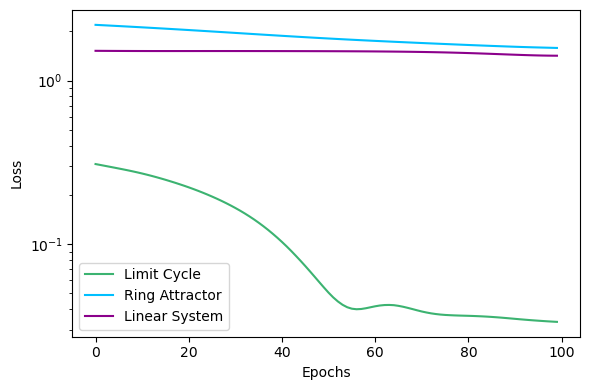

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
motif_names = ['Limit Cycle', 'Ring Attractor', 'Linear System']
motif_colors = ["mediumseagreen", "#00BFFF", "#8B008B"]

for i in range(len(motif_library)):
    ax.plot(homeo_networks[i].losses, label=motif_names[i], color=motif_colors[i])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
#find asymptotic behavior of target and source motifs
time_span = np.array([0.0, 100.0])
plot_first_n = 1

t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    init_points_bounds=bounds,                 # Define the bounds for initial conditions
    time_span=torch.tensor(time_span), # Time span for trajectory generation
    dt=dt, num_points=plot_first_n,                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)

trajectories_target_array = np.array([traj.detach().numpy() for traj in trajectories_target])
trajectories_source_list, transformed_trajectories_list = test_homeo_networks(
    trajectories_target, motif_library, homeo_networks, generate_trajectories_scipy,
    plot_first_n, plot_first_n=plot_first_n,
        time_span = time_span

)

c:\Users\abel_\Documents\Lab\Projects\topological_diversity\iam\scripts\ds_class.py:393: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_conditions = torch.tensor(predefined_initial_conditions, dtype=torch.float32)


(1, 2000, 2)

['Target', 'Transformed Limit Cycle', 'Transformed Ring Attractor', 'Transformed Linear']


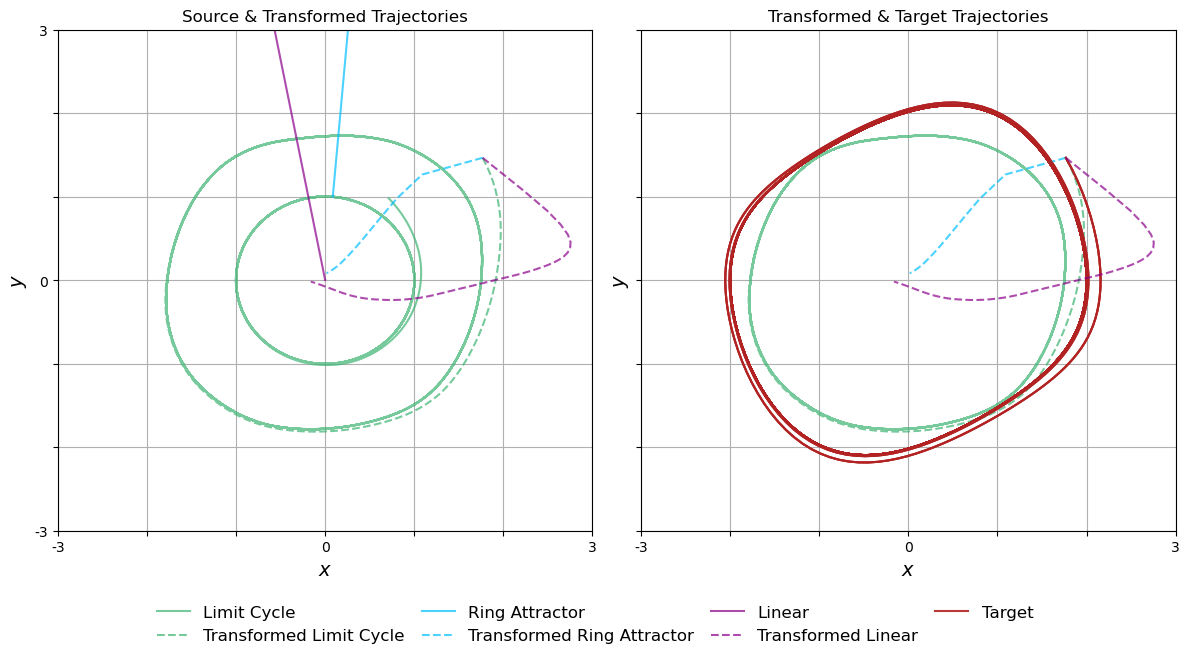

In [ ]:
from_t = 100
fig, axes = plot_trajectories_allmotifs(trajectories_source_list[:], transformed_trajectories_list[:], trajectories_target_array[:plot_first_n,:], bounds=(3.0, 3.0),
                            source_names=['Limit Cycle', 'Ring Attractor', 'Linear'],
                            save_name=f'figures/nf_epoch{num_epochs}_all_motifs_vdp_ntraj{plot_first_n}.pdf')